In [149]:
import os
import scanpy as sc
import scvi
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

## Load the data

CSV data should have genes in columns and cells in rows. We will transpose (`.T`) the imported CSV files so that it complies with scanpy's format. We load the dataset into the `adata` dataframe.

In [2]:
os.chdir('/home/pranav/work/pranavmishra90/nextgen-analysis/lung-atlas-tutorial/')

adata = sc.read_csv('./data/GSM5226574_C51ctr_raw_counts.csv').T

### What's inside the `adata` dataframe

In [3]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [25]:
# Cell barcodes
adata.obs

,_scvi_batch,_scvi_labels,doublet
TAGGTACCATGGCCAC-1_1,0,0,False
ATTCACTGTAACAGGC-1_1,0,0,False
TAACTTCCAACCACGC-1_1,0,0,False
TTGGGTACACGACAAG-1_1,0,0,False
AGGCCACAGAGTCACG-1_1,0,0,False
...,...,...,...
CGCCATTGTTTGCCGG-1_1,0,0,False
CACTGGGGTCTACGTA-1_1,0,0,False
CATACTTGTAGAGGAA-1_1,0,0,False
TTTGGTTTCCACGGAC-1_1,0,0,False


In [26]:
# Genes
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
TTLL10,112,True,903.0,0.028857,0.069354,1.901045
TNFRSF18,15,True,1604.0,0.002951,0.004911,1.513808
CFAP74,159,True,1370.0,0.041154,0.087024,1.607399
TTC34,209,True,245.0,0.080341,0.363502,3.044086
AJAP1,31,True,1922.0,0.006886,0.011432,1.421002
...,...,...,...,...,...,...
MT-ND4L,650,True,1212.0,0.191671,0.559353,1.695637
MT-ND4,1328,True,178.0,0.833087,9.742224,3.486984
MT-ND5,886,True,443.0,0.332514,1.669344,2.430210
MT-ND6,821,True,123.0,0.383178,3.357087,3.985056


In [27]:
# Counts
adata.X

array([[ 7.,  0.,  5., ...,  6., 44.,  6.],
       [ 1.,  0.,  2., ..., 20., 67., 22.],
       [ 0.,  0.,  0., ..., 14., 10., 13.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
adata.X.shape

## Pre-processing

### Doublet removal (optional, preferred)

In scRNA-seq, it is possible for 2+ cells to be present in the same droplet. Ideally, we would like to keep each droplet standardized. The python package `scvi` can be used.

In [4]:
# Limit that for a gene to be counted, it should be present in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [5]:
# Limit so that we only select the top 2000 genes
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

### Single Cell Variation Interface Tools (`scvi-tools`)



In [6]:
scvi.model.SCVI.setup_anndata(adata)

vae = scvi.model.SCVI(adata)

vae.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [14:26<00:00,  2.19s/it, v_num=1, train_loss_step=310, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:26<00:00,  2.17s/it, v_num=1, train_loss_step=310, train_loss_epoch=323]


	No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
	GPU available: False, used: False
	TPU available: False, using: 0 TPU cores
	IPU available: False, using: 0 IPUs
	HPU available: False, using: 0 HPUs
	Epoch 400/400: 100%|██████████| 400/400 [14:26<00:00,  2.19s/it, v_num=1, train_loss_step=310, train_loss_epoch=323]`Trainer.fit` stopped: `max_epochs=400` reached.
	Epoch 400/400: 100%|██████████| 400/400 [14:26<00:00,  2.17s/it, v_num=1, train_loss_step=310, train_loss_epoch=323]

In [7]:
solo = scvi.external.SOLO.from_scvi_model(vae)

solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 153/400:  38%|███▊      | 153/400 [01:23<02:14,  1.84it/s, v_num=1, train_loss_step=0.265, train_loss_epoch=0.297]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.272. Signaling Trainer to stop.


#### See if we have doublets


Below, we will show a dataframe that has each cell barcode with a corresponding score for `doublet` and `singlet`. The higher score is more likely and will become the 'prediction'


In [34]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.528965,-0.912366,doublet
ATTCACTGTAACAGGC-1_1,0.584071,-0.702253,doublet
TAACTTCCAACCACGC-1_1,-1.253529,0.437695,singlet
TTGGGTACACGACAAG-1_1,0.563384,-0.519752,doublet
AGGCCACAGAGTCACG-1_1,0.101313,-0.444742,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-1.330364,1.050433,singlet
CACTGGGGTCTACGTA-1_1,-2.979720,3.108930,singlet
CATACTTGTAGAGGAA-1_1,-2.492893,1.834626,singlet
TTTGGTTTCCACGGAC-1_1,-3.054057,2.656173,singlet


In [35]:
# df.index = df.index.map(lambda x : x[:-2]) #strip off the last 2 characters in the index column which are added by scvi

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.528965,-0.912366,doublet
ATTCACTGTAACAGGC-1_1,0.584071,-0.702253,doublet
TAACTTCCAACCACGC-1_1,-1.253529,0.437695,singlet
TTGGGTACACGACAAG-1_1,0.563384,-0.519752,doublet
AGGCCACAGAGTCACG-1_1,0.101313,-0.444742,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-1.330364,1.050433,singlet
CACTGGGGTCTACGTA-1_1,-2.979720,3.108930,singlet
CATACTTGTAGAGGAA-1_1,-2.492893,1.834626,singlet
TTTGGTTTCCACGGAC-1_1,-3.054057,2.656173,singlet


When counting the number of singlets and doublets, we find that about 22% of the data is doublets. We could dump all of these datapoints if we wanted. However, this would be a sizeable amount of data to completely filter out.

In [36]:
display(df.groupby('prediction').count())
display(1108/4991)

,doublet,singlet
prediction,,
doublet,1108,1108
singlet,4991,4991


0.22199959927870166

In [37]:
df['diff'] = df['doublet'] - df['singlet']
df

,doublet,singlet,prediction,diff
TAGGTACCATGGCCAC-1_1,0.528965,-0.912366,doublet,1.441330
ATTCACTGTAACAGGC-1_1,0.584071,-0.702253,doublet,1.286324
TAACTTCCAACCACGC-1_1,-1.253529,0.437695,singlet,-1.691224
TTGGGTACACGACAAG-1_1,0.563384,-0.519752,doublet,1.083136
AGGCCACAGAGTCACG-1_1,0.101313,-0.444742,doublet,0.546056
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-1.330364,1.050433,singlet,-2.380797
CACTGGGGTCTACGTA-1_1,-2.979720,3.108930,singlet,-6.088650
CATACTTGTAGAGGAA-1_1,-2.492893,1.834626,singlet,-4.327518
TTTGGTTTCCACGGAC-1_1,-3.054057,2.656173,singlet,-5.710229


Now we will plot the distribution of the differences scores to determine what would be a good cutoff point.

Text(0.5, 0, 'Doublet - Singlet Score')

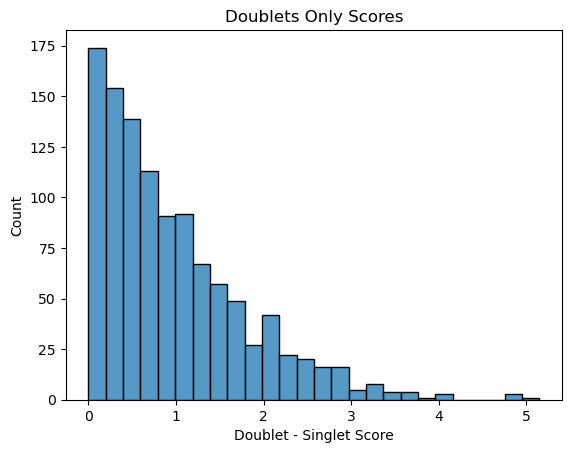

In [38]:
ax1 = sns.histplot(df[df['prediction'] == 'doublet'], x = 'diff')
ax1.set_title('Doublets Only Scores')
ax1.set_xlabel('Doublet - Singlet Score')

We will arbitrarily choose a cutoff value of `1`, where we will define a doublet only when the difference in score is `>1`

In [39]:
doublets = df[(df['prediction'] == 'doublet') & (df['diff'] > 1)]
doublets

,doublet,singlet,prediction,diff
TAGGTACCATGGCCAC-1_1,0.528965,-0.912366,doublet,1.441330
ATTCACTGTAACAGGC-1_1,0.584071,-0.702253,doublet,1.286324
TTGGGTACACGACAAG-1_1,0.563384,-0.519752,doublet,1.083136
ACTGATGTCTGCACCT-1_1,0.781898,-1.142981,doublet,1.924879
CCACGAGTCTCTTAAC-1_1,0.757953,-1.969527,doublet,2.727479
...,...,...,...,...
ATTCTTGGTGGCTTAT-1_1,0.444071,-1.140102,doublet,1.584172
CCACGTTGTAGAATGT-1_1,0.307891,-0.790417,doublet,1.098308
CAATACGCAATGTGGG-1_1,0.201349,-0.897185,doublet,1.098534
TGCCGAGCATTCTCTA-1_1,0.439634,-0.937567,doublet,1.377201


We have determined that 434 cells are, in fact, doublets. Using the cell barcodes (doublets.index), we can label the `adata` dataframe accordingly.

We will reload the `adata` dataframe from the `.csv` file as a "fresh start" from all of the calculations / manipulations we performed above.

### Reload data and filter

In [103]:
adata = sc.read_csv('./data/GSM5226574_C51ctr_raw_counts.csv').T

adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


Now, we will filter out the rows which have `'doublet' == True`

In [104]:
adata = adata[~adata.obs.doublet]
adata

View of AnnData object with n_obs × n_vars = 5665 × 34546
    obs: 'doublet'

After removing the doublets, we have 5665 cells remaining

#### Finding mitochondrial genes that start with "MT-"

In [105]:
adata.var[adata.var.index.str.startswith('MT-')]

""
MT-ND1
MT-ND2
MT-CO1
MT-CO2
MT-ATP8
MT-ATP6
MT-CO3
MT-ND3
MT-ND4L
MT-ND4


Now we can annotate the `adata` dataframe with a `True / False` value for whether or not it is a mitochondrial gene

In [106]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var

/tmp/ipykernel_966283/3248256402.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


#### Finding ribosomal genes

We are using a set from the Broad Institute for a list of ribosomal genes

In [107]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [108]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


### Quaility Control Metrics

We will use the mitochondrial and ribosomal genes to determine the quality 

In [109]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True
)


In [110]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,7,0.001236,99.876434,7.0
AL627309.5,False,False,29,0.005119,99.488085,29.0
AL627309.4,False,False,3,0.000530,99.947043,3.0
AL669831.2,False,False,2,0.000353,99.964695,2.0
LINC01409,False,False,233,0.044660,95.887026,253.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


`pct_dropout_by_counts`: for a large number of genes, the percent of cells which are dropped is nearly 100%. The number of cells expressing the genes can be seen in the `n_cells_by_counts` column

In [111]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413
CACTGAAGTCGAAGCA-1_1,False,5487,12725.0,355.0,2.789784,82.0,0.644401
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


For the dataframe above, we have the following columns

**index**: cell barcode

**doublet**: is the barcode corresponding to a suspected doublet cell

**n_genes_by_counts**: number of genes detected in the cell

**total_counts**: total number of genes copies which have been detected

**total_counts_mt**: total number of mitochondrial gene copies detected

**pct_counts_mt**: percentage of the detected genes which are mitochondrial, in a given cell

**total_counts_ribo**: total number of ribosomal gene copies detected

**pct_counts_ribo**: percentage of the detected genes which are ribosomal, in a given cell

In [112]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
AC079341.2,False,False,0,0.000000,100.000000,0.0
IL21,False,False,0,0.000000,100.000000,0.0
AC053545.1,False,False,0,0.000000,100.000000,0.0
AC082650.2,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4065,2.885967,28.243601,16349.0
MBNL1,False,False,4150,2.690380,26.743160,15241.0
NEAT1,False,False,4157,5.070256,26.619594,28723.0
ZBTB20,False,False,4299,2.429479,24.112974,13763.0


**Interpretation:**

MALAT1 has a percent dropout of 0.16, which means that it is found in over 99% of cells. Conversely, AL445072.1 was not detected in any cells and has a 100% dropout

### Filter out low expressing genes

We will now remove all genes that are not present in at least 3 cells

In [113]:
sc.pp.filter_genes(adata, min_cells = 3)

display(adata.var.sort_values('n_cells_by_counts'))

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL596087.2,False,False,3,0.000530,99.947043,3.0,3
AP003396.3,False,False,3,0.000530,99.947043,3.0,3
AP001150.1,False,False,3,0.000883,99.947043,5.0,3
OR8A1,False,False,3,0.000530,99.947043,3.0,3
SENCR,False,False,3,0.000530,99.947043,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4065,2.885967,28.243601,16349.0,4065
MBNL1,False,False,4150,2.690380,26.743160,15241.0,4150
NEAT1,False,False,4157,5.070256,26.619594,28723.0,4157
ZBTB20,False,False,4299,2.429479,24.112974,13763.0,4299


We now have about 24k genes (from a previous 34k genes) after filtering out genes that were expressed in only 1-2 cells

### Filter out cells with not that many genes being counted

In [114]:
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
AGGCATTCATCCGTTC-1_1,False,290,401.0,1.0,0.249377,0.0,0.000000
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
CACTGAAGTCGAAGCA-1_1,False,5487,12725.0,355.0,2.789784,82.0,0.644401
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413


It appears that this data has already been pre-QC-controlled. The least number of genes detected in a cell is 401, with many cells having this value. It is likely that the authors chose a cutoff at 400, excluding all cells that had 400 or fewer gene counts detected.

### Filter out cells with not many different genes being detected



In [115]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,False,276,419.0,1.0,0.238663,1.0,0.238663
CGTGCTTCAAAGGGCT-1_1,False,277,432.0,41.0,9.490741,0.0,0.000000
TGACAGTTCTAAACGC-1_1,False,278,414.0,0.0,0.000000,0.0,0.000000
CTCTGGTCACGACGAA-1_1,False,285,407.0,0.0,0.000000,0.0,0.000000
GTAAGTCGTATCGCGC-1_1,False,289,430.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TGGGAAGTCAGTGATC-1_1,False,4719,11238.0,92.0,0.818651,11.0,0.097882
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
CACTGAAGTCGAAGCA-1_1,False,5487,12725.0,355.0,2.789784,82.0,0.644401


In [116]:
# This filter will not do anything for the current dataset, as the smallest number of genes in a given cell is 276
sc.pp.filter_cells(adata, min_genes = 200)

### Plot Quality Control Metrics

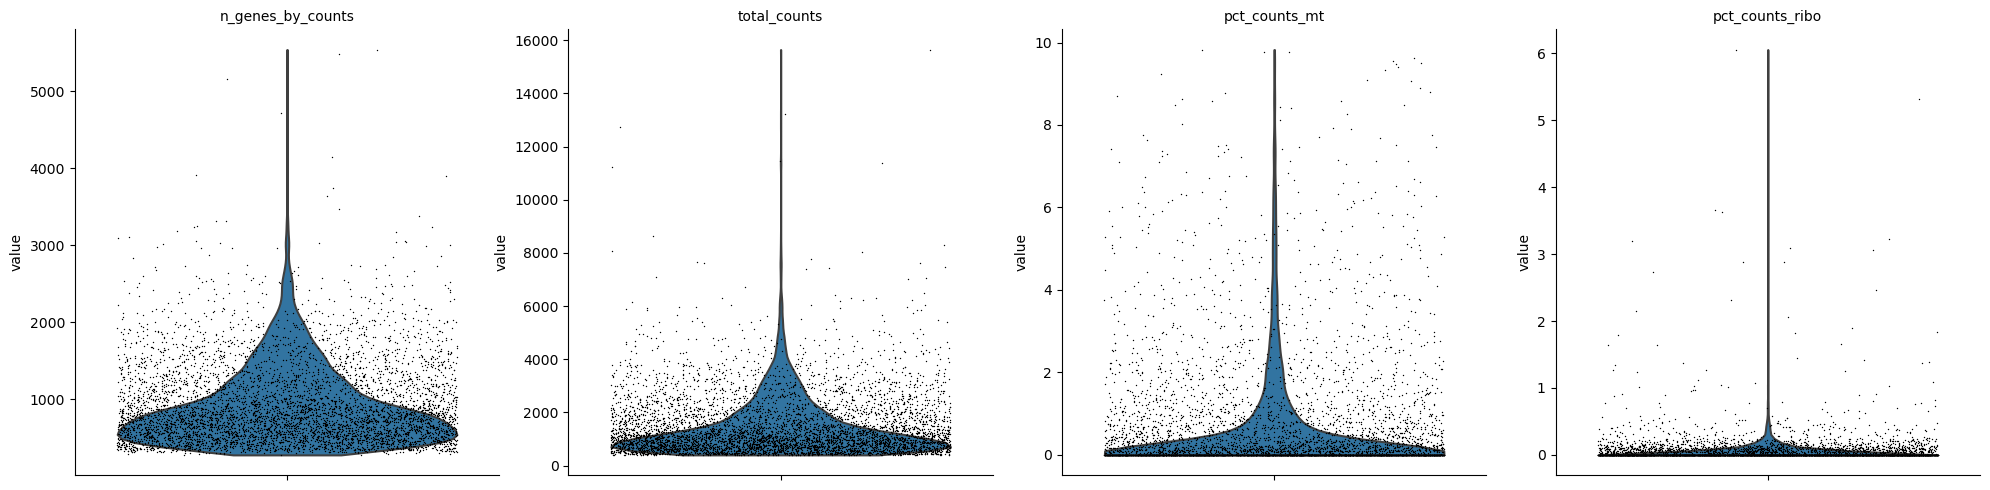

In [117]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter = 0.4, multi_panel = True)

### Filter outliers based on percentile

In [118]:
# Cutoff at the 98th percentile
genes_upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
display(genes_upper_lim)

2309.4400000000005

In [119]:
adata = adata[adata.obs.n_genes_by_counts < genes_upper_lim]
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,2275
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778,2280
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2228
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299


In [120]:
# Cutoff mitochondrial at the 20%
adata = adata[adata.obs.pct_counts_mt.values < 20]

adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,2275
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778,2280
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2228
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299


In [121]:
# Cutoff ribosomal at the 2%

adata = adata[adata.obs.pct_counts_ribo.values < 2]

adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,2275
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778,2280
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2228
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299


Now our data is considered 'clean' or 'quality-controlled'. We have removed **doublets** and **outliers**.

## Normalization

Each row of `adata.X` is a cell. If we add up the array values across a row, we will get the `total_counts` seen in `adata.obs`. We want to normalize every cell, so that the total number of genes counted = 10,000 UMI. 

**UMI**: unique molecular identifier

In [122]:
adata.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 1., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [123]:
adata.X.sum(axis = 1)

ArrayView([5433., 5250., 5050., ...,  410.,  405.,  410.], dtype=float32)

In [124]:
# Normalizing to 10,000 unique molecular identifiers
sc.pp.normalize_total(adata, target_sum = 1e4)

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [125]:
adata.X.sum(axis = 1)

array([10000.   , 10000.001, 10000.   , ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

In [126]:
# Convert to log counts

sc.pp.log1p(adata)

We do not expect the log total UMI counts to be the same in each cell, because the log transformation of a normalized dataset is non-linear

In [127]:
adata.X.sum(axis = 1)

array([3285.3794, 2858.1602, 3197.6338, ..., 1191.2706, 1022.7512,
       1162.8785], dtype=float32)

### Save the post-qc-raw-data

`adata.raw` is what scanpy uses to perform many of its internal calculations. Here we will define the raw data to be the dataset after performing all of the above quality controls

In [128]:
adata.raw = adata

## Clustering

In [129]:
## Find the 2000 most variable genes

sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,7,0.001236,99.876434,7.0,7,False,0.011649,2.722135,1.122879
AL627309.5,False,False,29,0.005119,99.488085,29.0,29,False,0.030023,2.277815,-0.219210
AL627309.4,False,False,3,0.000530,99.947043,3.0,3,False,0.002510,1.703049,-1.955319
LINC01409,False,False,233,0.044660,95.887026,253.0,233,False,0.262457,2.335893,-0.043784
FAM87B,False,False,5,0.000883,99.911739,5.0,5,False,0.005665,1.888166,-1.396165
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,121,0.022065,97.864078,125.0,121,False,0.156550,2.411319,0.184044
AL592183.1,False,False,862,0.179876,84.783760,1019.0,862,False,0.867446,2.516949,-0.374673
AC240274.1,False,False,138,0.024890,97.563989,141.0,138,False,0.147987,2.316479,-0.102424
AC007325.4,False,False,4,0.000706,99.929391,4.0,4,False,0.003015,1.579802,-2.327595


Additional columns have been added to the `adata.var` dataframe. 

**highly_variable**: Is the gene highly variable - True / False

**means**: statistical mean

**dispersions**: a measure of variability within the 'highly variable genes'

**dispersions_norm**: higher variable genes identified

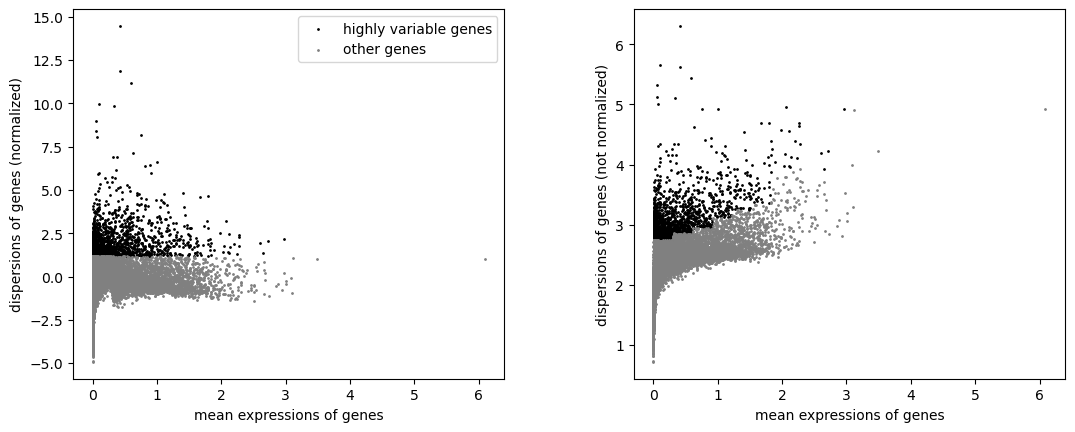

In [130]:
sc.pl.highly_variable_genes(adata)

In [131]:
# We will now only have 2000 of the top highly variable genes
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 5536 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We now want to regress out the dataset using the total gene counts and amount of mitochondrial / ribosomal genes that are found. This acts as another quality control / normalization step

In [132]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

Normalize each gene to the 'unit variance' of the gene

In [133]:
sc.pp.scale(adata, max_value = 10)

### Principle component analysis

Dimensionality reduction. We can plot how many principle components are detected and how much each contributes to the overall variance in the data. Then we can choose a cutoff of # of principle components to enter into our model (the elbow of the plot).

If we expect a higher number of cell types in the tissue we provided, we should expect a higher number of principle components.

In [134]:
sc.tl.pca(adata, svd_solver='arpack')

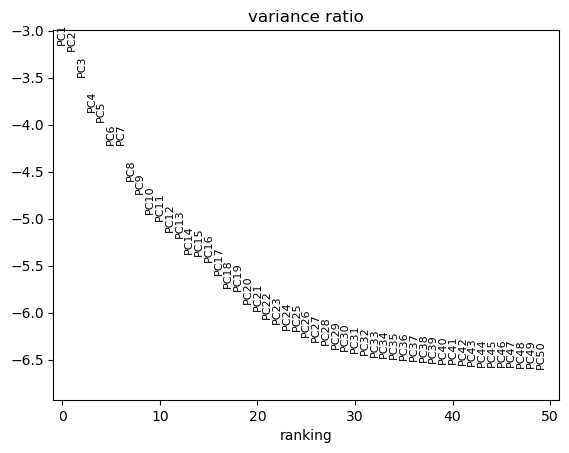

In [135]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

#### Finding the neighbors

In [136]:
# We will be choosing a value of 30 principle components

sc.pp.neighbors(adata, n_pcs = 30)

/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pranav/mambaforge/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecatio

adata now has a new component, **`obsp`**, with objects '**distances**' and '**connectivities**'. These are a cell-wise matrix of connections and their distances between each cell.

In [138]:
adata

AnnData object with n_obs × n_vars = 5536 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [139]:
adata.obsp['connectivities']

<5536x5536 sparse matrix of type '<class 'numpy.float32'>'
	with 113700 stored elements in Compressed Sparse Row format>

In [140]:
adata.obsp['connectivities'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [141]:
adata.obsp['distances'].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 4.05138969, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.05138969, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Create a UMAP Plot

From our input of 30 dimensions (30 principle components), we will reduce it to 2D so that it can be easily visulized in a figure

In [142]:
sc.tl.umap(adata)

/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


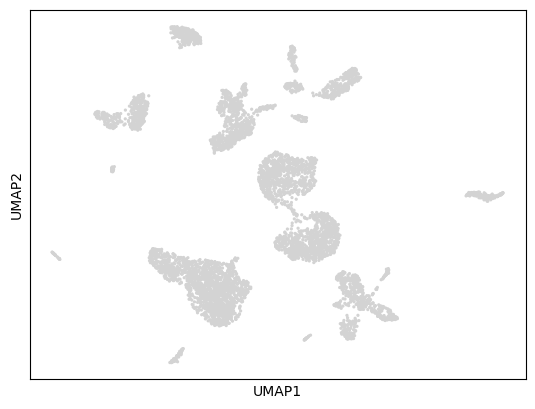

In [143]:
sc.pl.umap(adata)

In the above plot, each dot is corresponding to a singular cell. Clusters, though, have not been assigned yet. To determine which cell belongs in which cluster, we will use the leidenalg algorithm.

In [146]:
sc.tl.leiden(adata, resolution = 0.5)

In [147]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,2275,10
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120,2
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778,2280,2
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261,2
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2228,2
...,...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355,6
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299,11


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


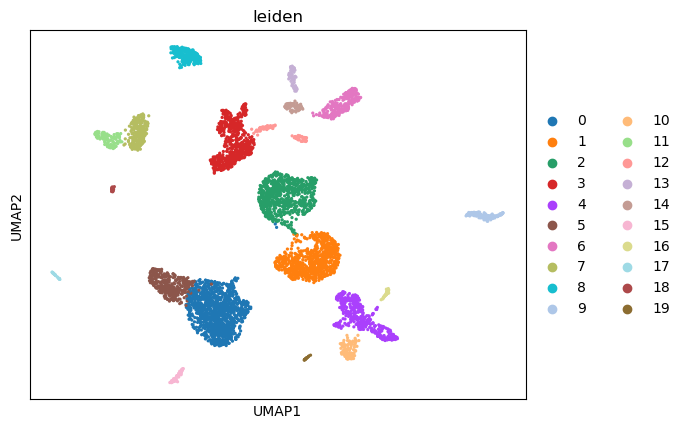

In [148]:
sc.pl.umap(adata, color=['leiden'])

## Integration

Combining together multiple samples by looping through each one and creating a quality-controlled `adata` object

In [150]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T

    adata.X = csr_matrix(adata.X)

    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]



    return adata

In [154]:
combined_adata = []

for file in os.listdir('./data/'):
    combined_adata.append(pp('./data/' + file))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [10:33<00:00,  1.55s/it, v_num=1, train_loss_step=350, train_loss_epoch=327]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:33<00:00,  1.58s/it, v_num=1, train_loss_step=350, train_loss_epoch=327]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 213/400:  53%|█████▎    | 213/400 [01:17<01:08,  2.74it/s, v_num=1, train_loss_step=0.274, train_loss_epoch=0.288]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.273. Signaling Trainer to stop.


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [07:14<00:00,  1.05s/it, v_num=1, train_loss_step=298, train_loss_epoch=335]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [07:14<00:00,  1.09s/it, v_num=1, train_loss_step=298, train_loss_epoch=335]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 182/400:  46%|████▌     | 182/400 [00:47<00:56,  3.86it/s, v_num=1, train_loss_step=0.248, train_loss_epoch=0.288]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [09:46<00:00,  1.40s/it, v_num=1, train_loss_step=288, train_loss_epoch=340]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:46<00:00,  1.47s/it, v_num=1, train_loss_step=288, train_loss_epoch=340]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 195/400:  49%|████▉     | 195/400 [01:07<01:10,  2.91it/s, v_num=1, train_loss_step=0.302, train_loss_epoch=0.298]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.292. Signaling Trainer to stop.


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [09:02<00:00,  1.34s/it, v_num=1, train_loss_step=353, train_loss_epoch=319]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:02<00:00,  1.36s/it, v_num=1, train_loss_step=353, train_loss_epoch=319]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 192/400:  48%|████▊     | 192/400 [01:00<01:05,  3.16it/s, v_num=1, train_loss_step=0.402, train_loss_epoch=0.31] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.321. Signaling Trainer to stop.


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [14:08<00:00,  2.06s/it, v_num=1, train_loss_step=327, train_loss_epoch=325]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:08<00:00,  2.12s/it, v_num=1, train_loss_step=327, train_loss_epoch=325]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 256/400:  64%|██████▍   | 256/400 [02:08<01:12,  1.99it/s, v_num=1, train_loss_step=0.317, train_loss_epoch=0.287]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.276. Signaling Trainer to stop.


/home/pranav/mambaforge/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 62/400:  15%|█▌        | 61/400 [01:15<06:52,  1.22s/it, v_num=1, train_loss_step=229, train_loss_epoch=329]

In [ ]:
adata = sc.concat(combined_adata)
adata.write_h5ad('combined.h5ad')